# Maximum Dissimilarity Algorithm (MDA)

Once the wave reanalysis data has been calibrated and validated (refer to the repository <b>CalValWaves</b> for more detailed information in this way), a hybrid downscaling method to shallower water is proposed so a high resolution wave climate in the coast can be obtained all over the world. This resolution depends on two main factors:

- The resolution of the bathymetry used, which depends on the data available, as a global bathymetry grid is proportioned by GEBCO and will be used here so it can be extended worldwide, but more detailed grids can be obtained (also shown in this project).

- The computational capacity of the machines used (it will make sense in the propagation step).

In this way, the first step to carry out this downscaling method is the selection of the maximum dissimilar cases, so the posterior propagation of the cases can be performed correctly (Javier Tausia, 2020, main directory of the repository). For this purpose, a certain number of windseas and swells is selected from the total set of 40 years so these two type of waves can be more or less represented. The way this selection is performed is described in the image below and in the previously cited work:

![MDA croquis](../images/mda/mdacroquis.png)

This sketch shows the workflow followed in the selection step. The data is firstly normalized for the correct performance of the algorithm, then the euclidean distance is used for the calculation of the distance between the different vectors in the dataset. Finally, the selected data is de-normalized so it can be used and plotted together with the original information.

As it can be seen, the variables used in the definition of the windseas and the swells are different, and it is due to the fact that windseas and swells do not propagate equally and their characteristics are not the same. The variables used are:

\begin{equation*}
\textit{Windseas: } \:\: H_S \:\: T_P \:\: \theta_m \:\: \sigma_\theta \:\: W \:\: \theta_W
\end{equation*}

\begin{equation*}
\textit{Swells: } \:\: H_S \:\: T_P \:\: \theta_m \:\: \sigma_\theta \:\: \gamma
\end{equation*}

where $H_S$ is the significant wave height, $T_P$ is the peak period, $\theta_m$ is the mean wave direction, $\sigma_\theta$ is the dispersion or cleanliness, $W$ is the wind magnitude, $\theta_W$ is the wind direction and $\gamma$ (jonswap) gives an idea about the shape of the wave spectra.

In [1]:
# import the modules
import sys
import os
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mda_functions import MaxDiss_Simplified_NoThreshold as MDA

The first thing that is done is the selection of the <b>number of cases</b> that will be selected, worth the redundancy:

In [2]:
num_centroids = 20

Notice that the algorithm will not take too much time even if the number of cases is too large, maybe a few minutes, but when doing the propagations, the computational effort is larger, so be careful. Next, files are loaded and the preprocessing is performed:

In [3]:
p_hind = op.join(os.getcwd(), '..', 'data', 'hindcast')
dataframe_total = pd.read_pickle(op.join(p_hind, 'csiro_dataframe_sat_corr.pkl'))
# this sat_corr dataframe is the one obtained in CalValWaves, exactly the same!!

In [4]:
# two copies are done for the selection of the seas and the swells
sea = dataframe_total.copy()
swell = dataframe_total.copy()

In [5]:
print(dataframe_total.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360840 entries, 1979-01-01 00:00:00 to 2020-02-29 23:00:00
Data columns (total 29 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Hs         360840 non-null  float32
 1   Tm_01      360839 non-null  float32
 2   Tm_02      360840 non-null  float32
 3   Tp         360839 non-null  float32
 4   DirM       360839 non-null  float32
 5   DirP       360839 non-null  float32
 6   Spr        360839 non-null  float32
 7   Nwp        360840 non-null  float32
 8   U10        360840 non-null  float32
 9   V10        360840 non-null  float32
 10  W          360840 non-null  float64
 11  DirW       360832 non-null  float64
 12  Hsea       360840 non-null  float32
 13  Hswell1    360840 non-null  float32
 14  Hswell2    360840 non-null  float32
 15  Hswell3    360840 non-null  float32
 16  Tpsea      172510 non-null  float32
 17  Tpswell1   321377 non-null  float32
 18  Tpswell2   138960 non-null  fl

<div class="alert alert-block alert-info">
<b>Important:</b> One of the most important things for the correct usage of the software is the shape of the wave reanalysis data (hindcast information), as the variables must have the same names that are defined in the example data file named as <b>'csiro_dataframe_sat_corr.pkl'</b>. More information about the downloading of this hindcast data will be proportioned but at this moment, the data that will be used must have this mentioned shape that can be seen above.
</div>

For the <b>preprocessing</b> step, two different sets of data must be used:

- For the seas, a dataframe with the required variables is obtained.

- For the swells, all the different partitions must be joined (3 in this case), and all the variables must be included in this set.

Here, the code might not be touched except the case that more swells exist in the wave reanalysis that wanna be added in the selection of the swells dataset.

In [6]:
# SEA DATAFRAME
xys_sea = ['Hsea', 'Tpsea', 'Dirsea', 'Sprsea', 'W', 'DirW']
sea = sea[xys_sea].dropna(axis=0, how='any')
# limited dispersion threshold so the analysis is coherent
sea['Sprsea'][sea['Sprsea']<5] = 5

In [7]:
# SWELL DATAFRAME
xys_swell = ['Tm_02',
             'Hswell1', 'Tpswell1', 'Dirswell1', 'Sprswell1',
             'Hswell2', 'Tpswell2', 'Dirswell2', 'Sprswell2',
             'Hswell3', 'Tpswell3', 'Dirswell3', 'Sprswell3']
swell = swell[xys_swell]
swell = pd.DataFrame({'Tm_02': np.repeat(swell['Tm_02'], 3),
                      'Hswell': np.concatenate((swell['Hswell1'].values,
                                                swell['Hswell2'].values,
                                                swell['Hswell3'].values),
                                               axis=0),
                      'Tpswell': np.concatenate((swell['Tpswell1'].values,
                                                 swell['Tpswell2'].values,
                                                 swell['Tpswell3'].values),
                                                axis=0),
                      'Dirswell': np.concatenate((swell['Dirswell1'].values,
                                                  swell['Dirswell2'].values,
                                                  swell['Dirswell3'].values),
                                                 axis=0),
                      'Sprswell': np.concatenate((swell['Sprswell1'].values,
                                                  swell['Sprswell2'].values,
                                                  swell['Sprswell3'].values),
                                                 axis=0)})
swell = swell.dropna(axis=0, how='any')
# limited dispersion threshold so the analysis is coherent
swell['Sprswell'][swell['Sprswell']<5] = 5
swell['Gamma'] = np.power(swell['Tpswell'].values/\
                          (swell['Tm_02'].values * 1.411), 
                          -12.5439)
# limited shape of the spectrum threshold so the analysis is coherent
swell['Gamma'][swell['Gamma']<1] = 1
swell['Gamma'][swell['Gamma']>50] = 50

In [8]:
data = [sea, swell]
labels = [['Hsea', 'Tpsea', 'Dirsea', 'Sprsea', 'W', 'DirW'],
          ['Hswell', 'Tpswell', 'Dirswell', 'Sprswell', 'Gamma']]
names = [['$H_S$ [m]', '$T_P$ [s]', '$\u03B8_{m}$ [$\degree$]', 
          '$\sigma_{\u03B8}$ [$\degree$]', '$W_{speed}$ [m/s]', '$\u03B8_{W}$ [$\degree$]'],
         ['$H_S$ [m]', '$T_P$ [s]', '$\u03B8_{m}$ [$\degree$]', 
          '$\sigma_{\u03B8}$ [$\degree$]', '$\gamma$']]
title = ['sea', 'swell']
# input values for the MDA algorithm functions in functions.py
scalars = [[0,1,3,4], [0,1,3,4]]
directionals = [[2,5], [2]]


MaxDiss waves parameters: 172510 --> 20

   MDA centroids: 20/20


MaxDiss waves parameters: 507170 --> 20

   MDA centroids: 20/20



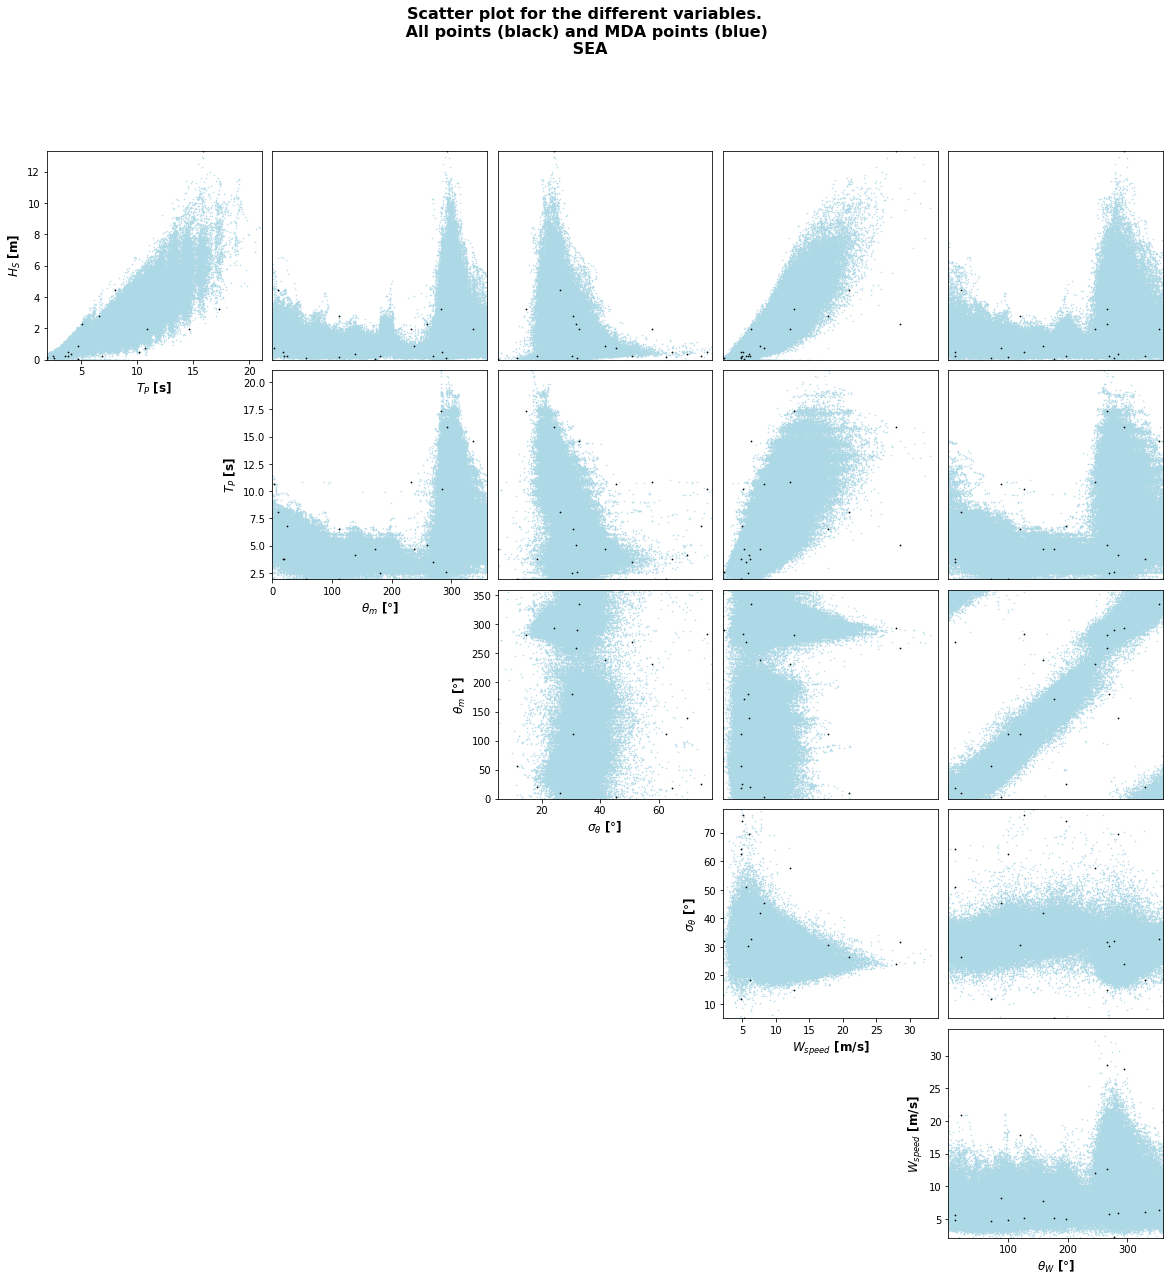

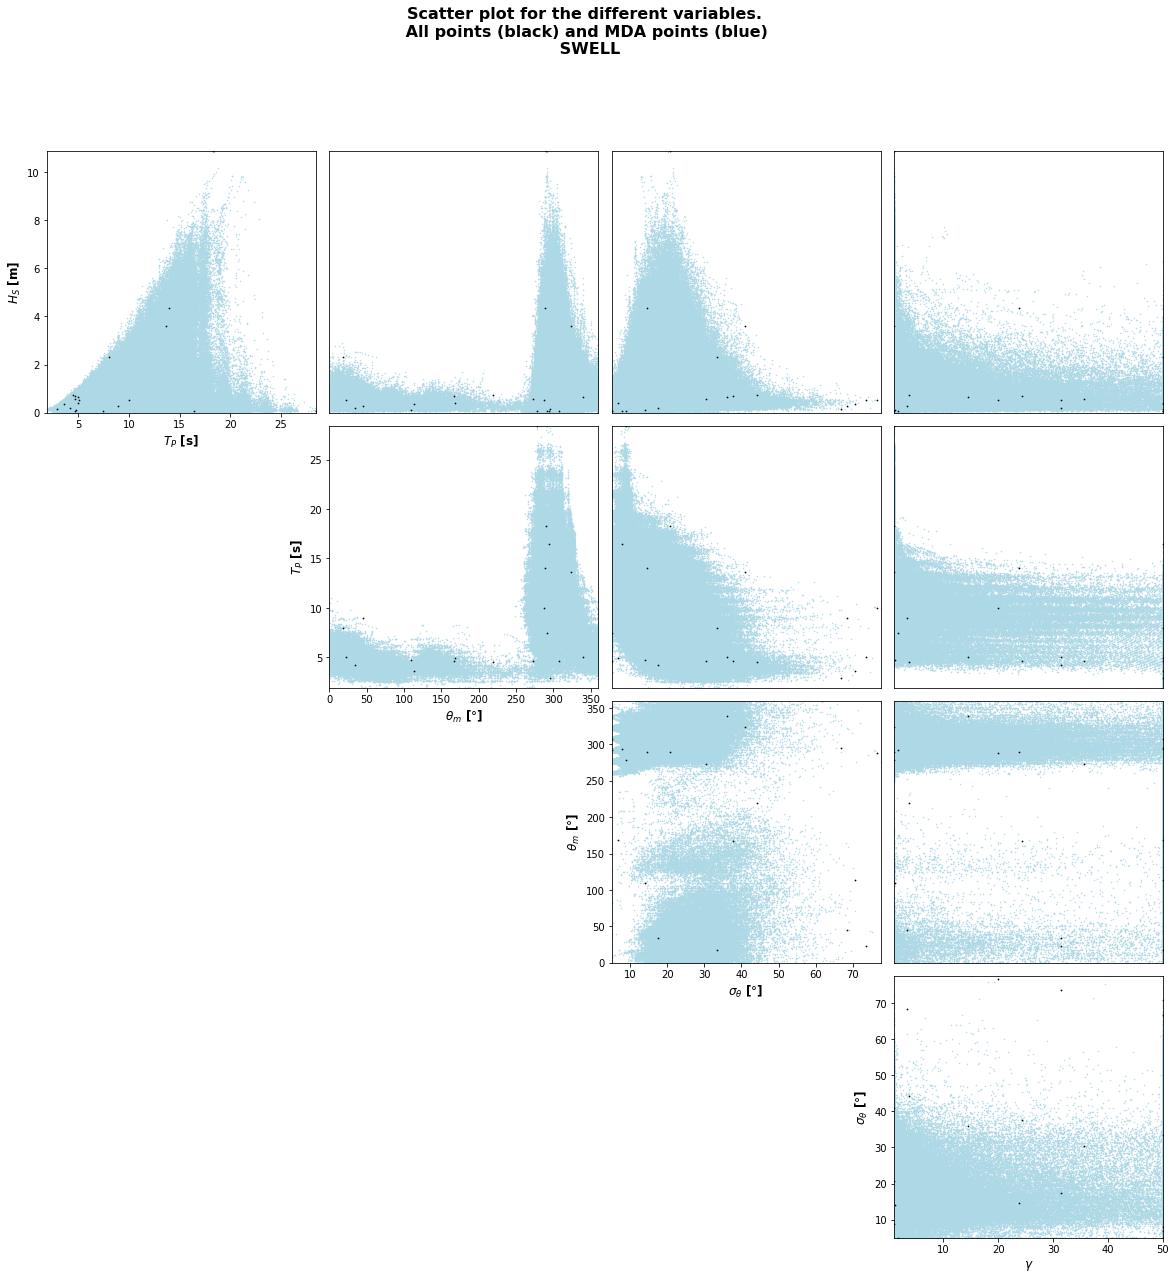

In [9]:
for wave in range(0,2):
    
    dataframe = data[wave]
    xys = labels[wave]
    xys_names = names[wave]
    scalar = scalars[wave]
    directional = directionals[wave]
    
    dataframe = dataframe[xys]
    dataarray = dataframe.to_numpy()

    # SUBSET
    subarray = MDA(dataarray, num_centroids, scalar, directional)
    subset = pd.DataFrame(subarray, columns=xys)

    # Scatter plot MDA centroids
    fig, axs = plt.subplots(len(xys)-1, len(xys)-1, figsize = (20,20))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.suptitle('Scatter plot for the different variables. \n ' + 
                 'All points (black) and MDA points (blue) \n ' +
                 title[wave].upper(), fontsize=16, fontweight='bold')

    for i, item in enumerate(xys):
        xys_copy = xys.copy()
        xys_names_copy = xys_names.copy()
        for p in range(i+1):
            xys_copy.pop(0)
            xys_names_copy.pop(0)
        for j, jtem in enumerate(xys_copy):
            axs[i,j+i].scatter(dataframe[jtem], dataframe[item], marker=".", 
                               s=1, color = 'lightblue')
            axs[i,j+i].scatter(subset[jtem], subset[item], marker=".", 
                               s=2,  color = 'k')
            axs[i,j+i].set_xlim(min(dataframe[jtem]), max(dataframe[jtem]))
            axs[i,j+i].set_ylim(min(dataframe[item]), max(dataframe[item]))
            if i==j+i:
                axs[i,j+i].set_xlabel(xys_names_copy[j], fontsize=12, 
                                      fontweight='bold')
                axs[i,j+i].set_ylabel(xys_names[i], fontsize=12, 
                                      fontweight='bold')
            else:
                axs[i,j+i].set_xticks([])
                axs[i,j+i].set_yticks([])
            len_xys = len(xys)-len(xys_copy)-1
            if len_xys != 0:
                for k in range(len_xys):
                    axs[i,k].axis('off')
    # data is saved in the data/hindcast folder         
    subset.to_pickle(op.join(p_hind, title[wave] + '_cases_' + str(num_centroids) + '.pkl'))